# DG tutorial w. Lagrange

In [1]:
#define imports
%matplotlib inline
import numpy as np
import matplotlib.pyplot as pl
from scipy.integrate import quad
from numpy.linalg import inv
from scipy.interpolate import lagrange
from scipy.special import roots_legendre

We'd now like to generate an interpolant for an arbitrary function using Lagrange polynomials evaluated at the roots of the Legendre polynomials.

In [2]:
#generate ID, a gaussian
def q_ID(x, mu, sigma):
    return np.exp(-(x-mu)**2./sigma**2.)

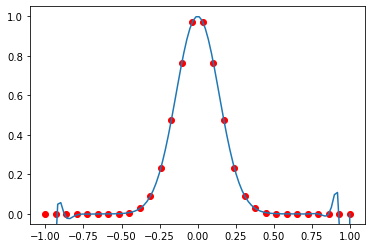

In [3]:
#define number of points to interpolate through; by construction
#of the Lagrange polynomials, this is equal to the degree of the
#interpolating polynomial
order = 30

#define x in -1, 1
mu    = 0
sigma = 0.2
x     = np.linspace(-1, 1, order)
y     = q_ID(x, mu, sigma)

x_upsampled = np.linspace(-1, 1, 100)

#generate Lagrange interpolating polynomial
l = lagrange(x, y)

pl.plot(x,y, 'ro')
pl.plot(x_upsampled, l(x_upsampled))
pl.ylim([-0.05, 1.05])
pl.show()

Notice that the result suffers from an oscillatory instability approaching the boundaries.  See [link] for an explanation.

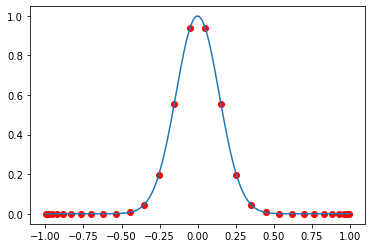

In [4]:
#instead of sampling x evenly, sample at roots of Legendre
roots, weights = roots_legendre(order)

x2 = roots
y2 = q_ID(x2, mu, sigma)

l2 = lagrange(x2, y2)

pl.plot(x2,y2, 'ro')
pl.plot(x_upsampled, l2(x_upsampled))
pl.show()

Note: scipy's implementation of the Lagrange interpolating polynomial breaks down above NumPoints ~ 30.

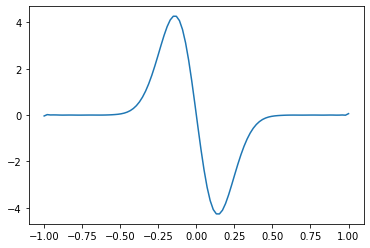

In [5]:
#we'll also need the derivative of this interpolating polynomial
pl.plot(x_upsampled, l2.deriv(1)(x_upsampled))

now we'd like to do the same thing above (namely, Lagrange interpolation using the roots of the Legendre polynomials as nodes) but _manually_, so we have a better understanding of what's going on under the hood, and so that we can compute the mass and stiffness matrices later on

In [11]:
#define Lagrange interpolating polynomial; take x in [-1, 1], nodes (list of Legendre roots up to order
#M)
def LagrangePoly(xi, j, nodes):
    order = len(nodes)
    
    poly  = 1
    for i in range(order):
        if(i != j):
            poly *= (xi-nodes[i])/(nodes[j]-nodes[i])
            
    return poly

#define first derivative of Lagrange polynomial
def dLagrangePoly(xi, j, nodes):
    order = len(nodes)
    
    poly = 0
    for i in range(order):
        if(i != j):
            poly += 1./(xi-nodes[i])
            
    poly *= LagrangePoly(xi, j, nodes)
    
    return poly

In [12]:
#compute mass matrix:
def Mij(nodes):
    order = len(nodes)
    
    M = np.zeros((order, order))
    for i in range(order):
        for j in range(order):
            M[i,j] = quad(lambda xi: 
                          LagrangePoly(xi,i,nodes)
                          *LagrangePoly(xi,j,nodes), -1, 1)[0]
            
    #set values smaller than eps to zero
    eps = 1e-15
    M[np.abs(M) < eps] = 0
    
    return M

#compute stiffness matrix; note that the first derivative
#of the Lagrange polynomials is numerically poorly behaved
#near the nodes, so pass points=nodes to quad to get it to
#treat those areas carefully
def Kij(nodes):
    order = len(nodes)
    
    K = np.zeros((order, order))
    
    for i in range(order):
        for j in range(order):
            K[i, j] = quad(lambda xi: 
                           dLagrangePoly(xi,i,nodes)
                           *LagrangePoly(xi,j,nodes), -1, 1,
                          points=nodes)[0]
    
    #set values smaller than eps to zero
    eps = 1e-15
    K[np.abs(K) < eps] = 0

    return K

In [44]:
#define solution approximation in element indexed k
#from coefficient matrix a_n[k, j]
def qt(k, xi, a_n, nodes):
    #a_n has shape (N elements, M modes)
    N, M = np.shape(a_n)
        
    q = 0
    for j in range(M):
        q += a_n[k, j]*LagrangePoly(xi, j, nodes)

    return q

In [109]:
#set up grid
N = 7 #number of elements
M = 7 #number of modes j

#get Legendre roots; we don't need weights
roots, weights = roots_legendre(M)

#define a_n to be a (N elements, M modes) array
a_n   = np.zeros((N, M))
a_np1 = np.zeros((N, M))

#define CFL
CFL = 0.05

#define number of timesteps, TS
TS = 250

#set up grid
xMax = 1.
xMin = 0.

#define size of a cell, dx
dx = (xMax-xMin)/N
dt = CFL * dx

#index cells from k = 0 to N; cell boundary is at (k*dx, [k+1]*dx); define array of boundaries cbound
cbound = [k*dx for k in range(N+1)]

#define wave speed c
c = 1.

In [110]:
#define initial data
def q_ID(x):
    mu = 0.5
    sigma = 0.05
    return np.exp(-(x-mu)**2./sigma**2.)

#define coordinate mapping
def x(k, xi):
    return k*dx + (1+xi)/2*dx

#populate coefficient matrix a_n with values corresponding to ID
def compute_ID_a(a_n, nodes):
    N, M = np.shape(a_n)
    
    for k in range(N):
        for j in range(M):
            xi        = nodes[j]
            a_n[k, j] = q_ID(x(k, xi))
            
    return a_n

In [111]:
a_np1 = compute_ID_a(a_n, roots)

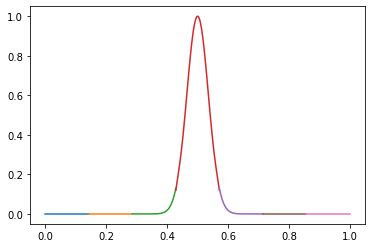

In [112]:
#xi in each element
xi = np.linspace(-1, 1, 100)

#plot approximate solution qtilde(x)
for k in range(N):
    pl.plot(x(k,xi), qt(k, xi, a_n, roots))

#pl.plot(x, q_ID(x))
#pl.plot(x, )